# 1. Setup

### Libraries

In [1]:
!pip install -qU ../input/for-pydicom/python_gdcm-3.0.14-cp37-cp37m-manylinux_2_17_x86_64.manylinux2014_x86_64.whl ../input/for-pydicom/pylibjpeg-1.4.0-py3-none-any.whl --find-links frozen_packages --no-index

ERROR: python_gdcm-3.0.14-cp37-cp37m-manylinux_2_17_x86_64.manylinux2014_x86_64.whl is not a supported wheel on this platform.


In [5]:
#!pip install seaborn
!pip install dipy

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 7.9 MB 31.3 MB/s            


In [78]:
!pip install efficientnet-pytorch==0.7.1
!pip install segmentation_models_pytorch==0.3.0
!pip install efficientnet_pytorch==0.7.1
!pip install https://www.kaggle.com/datasets/kozodoi/timm-pytorch-image-models?select=pytorch-image-models-master

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
     \ 13 kB 37.7 MB/s
  ERROR: Cannot unpack file /tmp/pip-unpack-a3zhu4wf/timm-pytorch-image-models (downloaded from /tmp/pip-req-build-wt6ntwta, content-type: text/html; charset=utf-8); cannot detect archive format
ERROR: Cannot determine archive format of /tmp/pip-req-build-wt6ntwta


In [1]:
import sys
import os

# sys.path.append("../input/pytorch-segmentation-models-lib/pretrainedmodels-0.7.4/pretrainedmodels-0.7.4")
# sys.path.append("../input/segmentationmoodel030/efficientnet_pytorch-0.7.1/efficientnet_pytorch-0.7.1")
# sys.path.append("../input/timm-pytorch-image-models/pytorch-image-models-master")
# sys.path.append("../input/segmentationmoodel030/segmentation_models_pytorch-0.3.0/segmentation_models_pytorch-0.3.0")
#os.makedirs("checkpoints",exist_ok=True)
#!cp ../../../../Data/Model_Optimization/2nd_model/RSNA2022RAWE/efficientnet-b0-355c32eb.pth checkpoints/

In [2]:
import sys
#sys.path.append("../input/timm-pytorch-image-models/pytorch-image-models-master")
import timm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.patches as patches
import seaborn as sns
sns.set(style='darkgrid', font_scale=1.6)
import cv2
import os
from os import listdir
import re
import gc
import random
import pydicom
from pydicom.pixel_data_handlers.util import apply_voi_lut
from tqdm.auto import tqdm
from pprint import pprint
from time import time
import itertools
from skimage import measure
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import nibabel as nib
from glob import glob
import warnings

import zipfile
from scipy import ndimage
from sklearn.model_selection import train_test_split
from joblib import Parallel, delayed
from PIL import Image
from dipy.denoise.nlmeans import nlmeans
from dipy.denoise.noise_estimate import estimate_sigma
from skimage import exposure

# Pytorch
import torch
import torch.nn as nn
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torch.nn.functional as F
import nibabel as nib
import pydicom as dicom
import gc 
import segmentation_models_pytorch as smp


In [3]:
class CFG:
    seed=42
    device='GPU' # ['TPU', 'GPU']
    nprocs=1 # [1, 8]
    num_workers=2
    valid_bs=32
    fold_num=5 
    
    target_cols=["C1", "C2", "C3", "C4", "C5", "C6", "C7", "OT"]
    num_classes=8 
    
    normalize_mean=[0.4824, 0.4824, 0.4824] 
    normalize_std=[0.22, 0.22, 0.22] 
    
    fold_list=[0]

    model_arch="efficientnet-b0" 
    img_size=512 
    croped_img_size = 320 # 裁剪后的图片尺寸
    weight_path = f"../../../../Data/Model_Optimization/2nd_model/RSNA2022RAWE/efficientnet-b0_109_fold0_epoch13.pth" 
    
# Config device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')    
datadir = "../../../../Data/RSNA_2022_DATA/rsna-2022-cervical-spine-fracture-detection"

In [4]:
def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True 

seed_everything(CFG.seed)

def load_dicom(path):
    """
    This supports loading both regular and compressed JPEG images. 
    See the first sell with `pip install` commands for the necessary dependencies
    """
    img = dicom.dcmread(path)
    img.PhotometricInterpretation = 'YBR_FULL'
    data = img.pixel_array
    data = data - np.min(data)
    if np.max(data) != 0:
        data = data / np.max(data)
    # data = (data * 255).astype(np.uint8)
    return data

In [5]:
test_df = pd.read_csv(f'{datadir}/test.csv')

debug = False
if len(test_df)==3:
    debug = True
    
    # Fix mismatch with test_images folder
    test_df = pd.DataFrame(columns = ['row_id','StudyInstanceUID','prediction_type'])
    for i in ['1.2.826.0.1.3680043.22327','1.2.826.0.1.3680043.25399','1.2.826.0.1.3680043.5876']:
        for j in ['C1','C2','C3','C4','C5','C6','C7','patient_overall']:
            test_df = test_df.append({'row_id':i+'_'+j,'StudyInstanceUID':i,'prediction_type':j},ignore_index=True)
    
    # Sample submission
    ss = pd.DataFrame(test_df['row_id'])
    ss['fractured'] = 0.5
    print(test_df.shape)

(24, 3)


/tmp/ipykernel_1486283/2532789708.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  test_df = test_df.append({'row_id':i+'_'+j,'StudyInstanceUID':i,'prediction_type':j},ignore_index=True)
/tmp/ipykernel_1486283/2532789708.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  test_df = test_df.append({'row_id':i+'_'+j,'StudyInstanceUID':i,'prediction_type':j},ignore_index=True)
/tmp/ipykernel_1486283/2532789708.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  test_df = test_df.append({'row_id':i+'_'+j,'StudyInstanceUID':i,'prediction_type':j},ignore_index=True)
/tmp/ipykernel_1486283/2532789708.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.co

In [6]:
test_study_list = np.unique(test_df["StudyInstanceUID"].values).tolist()
test_study_list[:3]

['1.2.826.0.1.3680043.22327',
 '1.2.826.0.1.3680043.25399',
 '1.2.826.0.1.3680043.5876']

In [7]:
# study_id_list = []
# slice_num_list = []
# for study_name in test_study_list:
#     slice_file_list = os.listdir(f"{datadir}/test_images/{study_name}")
#     slice_cnt = len(slice_file_list)
    
#     study_id_list.extend([study_name]*slice_cnt)
#     slice_num_list.extend([int(x.replace(".dcm","")) for x in slice_file_list])
# print(len(study_id_list), len(slice_num_list))

# all_slice_df = pd.DataFrame({"StudyInstanceUID":study_id_list, "slice_num":slice_num_list})
# all_slice_df = all_slice_df.sort_values(["StudyInstanceUID", "slice_num"]).reset_index(drop=True)
# all_slice_df.to_csv(f"./all_slice_df.csv", index=False)
# print(all_slice_df.shape)
# all_slice_df.head(3)

In [8]:
all_slice_list = []
for file_name in test_study_list:
    image_path_list = glob(f"{datadir}/test_images/{file_name}/*")
    image_path_list = sorted(image_path_list, key=lambda x:int(x.split("/")[-1].replace(".dcm","")))
    for path_idx in range(len(image_path_list)):
        path1 = "nofile" if path_idx-1 < 0 else image_path_list[path_idx-1].replace(f"{datadir}/test_images/", "")
        path2 = image_path_list[path_idx].replace(f"{datadir}/test_images/", "")
        path3 = "nofile" if path_idx+1 >= len(image_path_list) else image_path_list[path_idx+1].replace(f"{datadir}/test_images/", "")
        slice_num = int(path2.split("/")[-1].replace(".dcm",""))
        all_slice_list.append([f"{file_name}_{slice_num}", file_name, slice_num, path1, path2, path3])

In [9]:
slice_df = pd.DataFrame(all_slice_list, columns=["id", "StudyInstanceUID", "slice_num", "path1", "path2", "path3"])
slice_df

,id,StudyInstanceUID,slice_num,path1,path2,path3
0,1.2.826.0.1.3680043.22327_1,1.2.826.0.1.3680043.22327,1,nofile,1.2.826.0.1.3680043.22327/1.dcm,1.2.826.0.1.3680043.22327/2.dcm
1,1.2.826.0.1.3680043.22327_2,1.2.826.0.1.3680043.22327,2,1.2.826.0.1.3680043.22327/1.dcm,1.2.826.0.1.3680043.22327/2.dcm,1.2.826.0.1.3680043.22327/3.dcm
2,1.2.826.0.1.3680043.22327_3,1.2.826.0.1.3680043.22327,3,1.2.826.0.1.3680043.22327/2.dcm,1.2.826.0.1.3680043.22327/3.dcm,1.2.826.0.1.3680043.22327/4.dcm
3,1.2.826.0.1.3680043.22327_4,1.2.826.0.1.3680043.22327,4,1.2.826.0.1.3680043.22327/3.dcm,1.2.826.0.1.3680043.22327/4.dcm,1.2.826.0.1.3680043.22327/5.dcm
4,1.2.826.0.1.3680043.22327_5,1.2.826.0.1.3680043.22327,5,1.2.826.0.1.3680043.22327/4.dcm,1.2.826.0.1.3680043.22327/5.dcm,1.2.826.0.1.3680043.22327/6.dcm
...,...,...,...,...,...,...
1313,1.2.826.0.1.3680043.5876_454,1.2.826.0.1.3680043.5876,454,1.2.826.0.1.3680043.5876/453.dcm,1.2.826.0.1.3680043.5876/454.dcm,1.2.826.0.1.3680043.5876/455.dcm
1314,1.2.826.0.1.3680043.5876_455,1.2.826.0.1.3680043.5876,455,1.2.826.0.1.3680043.5876/454.dcm,1.2.826.0.1.3680043.5876/455.dcm,1.2.826.0.1.3680043.5876/456.dcm
1315,1.2.826.0.1.3680043.5876_456,1.2.826.0.1.3680043.5876,456,1.2.826.0.1.3680043.5876/455.dcm,1.2.826.0.1.3680043.5876/456.dcm,1.2.826.0.1.3680043.5876/457.dcm
1316,1.2.826.0.1.3680043.5876_457,1.2.826.0.1.3680043.5876,457,1.2.826.0.1.3680043.5876/456.dcm,1.2.826.0.1.3680043.5876/457.dcm,1.2.826.0.1.3680043.5876/458.dcm


# DataSet

In [10]:
# 构造 dataset类
class VoxelDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform
        
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        im2 = load_dicom(f"{datadir}/test_images/{row['path2']}")   # 512*512  
        im2h = im2.shape[0]
        im2w = im2.shape[1]

        im1 = load_dicom(f"{datadir}/test_images/{row['path1']}") if row['path1'] != "nofile" else np.zeros((im2h, im2w))  # 512*512                                                       
        im3 = load_dicom(f"{datadir}/test_images/{row['path3']}") if row['path3'] != "nofile" else np.zeros((im2h, im2w))  # 512*512  

        if im1.shape !=  (im2h, im2w):
            im1 = cv2.resize(im1, (im2w, im2h))
        if im3.shape !=  (im2h, im2w):
            im3 = cv2.resize(im3, (im2w, im2h)) 
        image_list = [im1, im2, im3]
        image = np.stack(image_list, axis=2) # 512*512*3; 0-1

        # transform
        if self.transform:
            augmented = self.transform(image=image)
            image = augmented['image']
        
        # image = image/255.0
        image = np.transpose(image, (2, 0, 1)) # 3*img_size*img_size; 0-1
        return torch.from_numpy(image), row['StudyInstanceUID'], row['slice_num'] 

In [11]:
from albumentations import CenterCrop, Resize, RandomCrop, GaussianBlur, JpegCompression, Downscale, ElasticTransform, Compose
import albumentations
from albumentations.pytorch import ToTensorV2

def get_transforms(data):
    if data == 'valid':
        return Compose([
            Resize(CFG.img_size, CFG.img_size, interpolation=cv2.INTER_NEAREST),
        ])

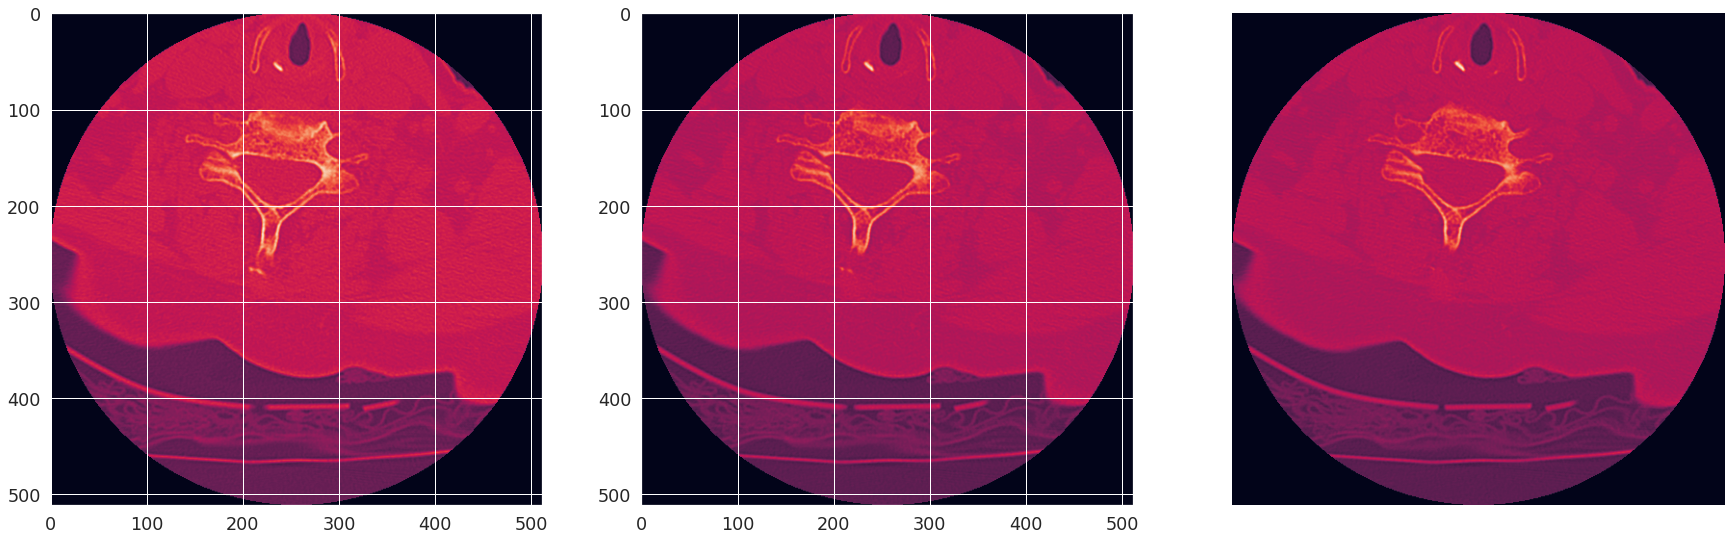

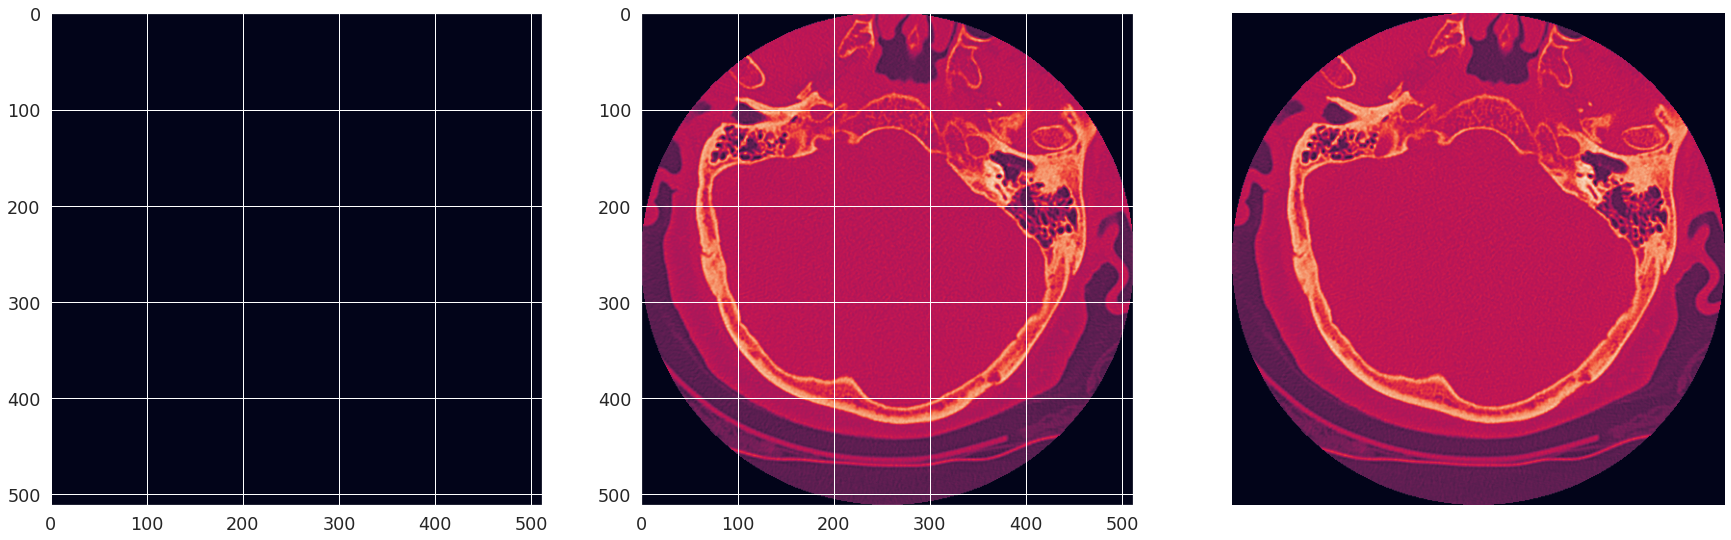

In [12]:
if debug:
    from pylab import rcParams
    dataset_show = VoxelDataset(
        slice_df, 
        get_transforms("valid") # None, get_transforms("train")
        )
    rcParams['figure.figsize'] = 30,20
    for i in range(2):
        f, axarr = plt.subplots(1,3)
        idx = np.random.randint(0, len(dataset_show))
        img, file_name, n_slice= dataset_show[idx]
        # axarr[p].imshow(img) # transform=None
        axarr[0].imshow(img[0]); plt.axis('OFF');
        axarr[1].imshow(img[1]); plt.axis('OFF');
        axarr[2].imshow(img[2]); plt.axis('OFF');

# Model

In [13]:
import segmentation_models_pytorch as smp

def build_model():
    model = smp.Unet(
        encoder_name=CFG.model_arch,    # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
        encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
        in_channels=3,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
        classes=CFG.num_classes,        # model output channels (number of classes in your dataset)
        activation=None,
    )
    model.to(device)
    return model

def load_model(path):
    model = build_model()
    model.load_state_dict(torch.load(path)["model"])
    model.eval()
    return model

In [14]:
slice_class_list = []
voxel_crop_list = []
def crop_voxel(voxel_mask, last_f_name):
    area_thr = 10
    # x
    x_list = []
    length = voxel_mask.shape[0]
    for i in range(length):
        if torch.count_nonzero(voxel_mask[i]).item() >= area_thr:
            x_list.append(i)
            break
    else:
        x_list.append(0)

    for i in range(length-1, -1, -1):
        if torch.count_nonzero(voxel_mask[i]).item() >= area_thr:
            x_list.append(i)
            break
    else:
        x_list.append(length-1)

    # y
    y_list = []
    length = voxel_mask.shape[1]
    for i in range(length):
        if torch.count_nonzero(voxel_mask[:, i]).item() >= area_thr:
            y_list.append(i)
            break
    else:
        y_list.append(0)

    for i in range(length-1, -1, -1):
        if torch.count_nonzero(voxel_mask[:, i]).item() >= area_thr:
            y_list.append(i)
            break
    else:
        y_list.append(length-1)

    # z
    z_list = []
    length = voxel_mask.shape[2]
    for i in range(length):
        if torch.count_nonzero(voxel_mask[:, :, i]).item() >= area_thr:
            z_list.append(i)
            break
    else:
        z_list.append(0)

    for i in range(length-1, -1, -1):
        if torch.count_nonzero(voxel_mask[:, :, i]).item() >= area_thr:
            z_list.append(i)
            break
    else:
        z_list.append(length-1)
    # croped_voxel = voxels[x_list[0]:x_list[1]+1, y_list[0]:y_list[1]+1, z_list[0]:z_list[1]+1]
    try:
        croped_voxel_mask = voxel_mask[x_list[0]:x_list[1]+1, y_list[0]:y_list[1]+1, z_list[0]:z_list[1]+1]
    except:
        print(f"last_f_name:{last_f_name}, voxel_mask.shape:{voxel_mask.shape}, x_list:{x_list}, y_list:{y_list}, z_list:{z_list}")
        x_list = [0, voxel_mask.shape[0]-1]; y_list = [0, voxel_mask.shape[1]-1]; z_list = [0, voxel_mask.shape[2]-1]
        croped_voxel_mask = voxel_mask
    voxel_crop_list.append([last_f_name, voxel_mask.shape[1], x_list[0], x_list[1]+1, y_list[0], y_list[1]+1, z_list[0], z_list[1]+1])

    # croped_voxel = croped_voxel.to('cpu').numpy() # bs*img_size*img_size; 0-8 classes
    croped_voxel_mask = croped_voxel_mask.to('cpu').numpy().astype(np.uint8) # bs*img_size*img_size; 0-8 classes
    for x_idx in range(croped_voxel_mask.shape[0]):
        slice_mask = croped_voxel_mask[x_idx]

        unique, counts = np.unique(slice_mask, return_counts=True)
        if len(unique) == 1 and unique[0] == 0:
            slice_class_list.append([last_f_name, x_idx, x_idx+x_list[0], 0])
        elif unique[0] == 0:
            unique = unique[1:]
            counts = counts[1:]
            slice_class_list.append([last_f_name, x_idx, x_idx+x_list[0]+1, unique[counts.argmax()]])
        else:
            slice_class_list.append([last_f_name, x_idx, x_idx+x_list[0]+1, unique[counts.argmax()]])
        
    return None, croped_voxel_mask

In [15]:
test_dataset = VoxelDataset(slice_df, transform=get_transforms("valid")) # get_transforms("valid")
test_loader = DataLoader(test_dataset, batch_size=CFG.valid_bs, shuffle=False, num_workers=CFG.num_workers, pin_memory=True, drop_last=False)

model = load_model(CFG.weight_path)
model.eval()
# model = torch.quantization.convert(model.eval(), inplace=False)

# optimizer = torch.optim.SGD(model.parameters(), lr = 5e-3)
# model.qconfig = torch.ao.quantization.get_default_qat_qconfig('fbgemm')
last_f_name = ""
voxel_mask = []
# voxels = []

In [16]:
for step, (images, file_names, n_slice) in tqdm(enumerate(test_loader),total=len(test_loader)):
    images = images.to(device, dtype=torch.float) # bs*3*image_size*image_size
    batch_size = images.size(0)
    with torch.no_grad():
        y_pred = model(images) # [B, 8, H, W]
    y_pred = y_pred.sigmoid()
    slice_mask_max = torch.max(y_pred, 1) # bs*img_size*img_size
    slice_mask = torch.where((slice_mask_max.values)>0.5, slice_mask_max.indices+1, 0) # bs*img_size*img_size; 0-8 classes
    slice_mask = torch.where(slice_mask==8,0,slice_mask).type(torch.uint8)
    # slice_mask = slice_mask.to('cpu').numpy().astype(np.uint8) # bs*img_size*img_size; 0-8 classes
    # slice_image = images[:, 1, :, :] # bs*img_size*img_size

    start_idx = 0
    for bs_idx in range(batch_size):
        f_name = file_names[bs_idx]
        if f_name != last_f_name:
            voxel_mask.append(slice_mask[start_idx:bs_idx])
            # voxels.append(slice_image[start_idx:bs_idx])
            voxel_mask = torch.cat(voxel_mask, dim=0) # n_slice*img_size*img_size; 0-8 classes
            # voxels = torch.cat(voxels, dim=0) # n_slice*img_size*img_size
            if len(voxel_mask) > 0:
                croped_voxel, croped_voxel_mask = crop_voxel(voxel_mask, last_f_name)
            last_f_name = f_name
            start_idx = bs_idx
            voxel_mask = []
            # voxels = []
        elif bs_idx == batch_size-1:
            voxel_mask.append(slice_mask[start_idx:batch_size])
            # voxels.append(slice_image[start_idx:batch_size])
voxel_mask = torch.cat(voxel_mask, dim=0)
if len(voxel_mask) > 0:
    croped_voxel, croped_voxel_mask = crop_voxel(voxel_mask, last_f_name)

  0%|          | 0/42 [00:00<?, ?it/s]

In [17]:
voxel_crop_df = pd.DataFrame(voxel_crop_list, columns=["StudyInstanceUID", "before_image_size", "x0", "x1", "y0", "y1", "z0", "z1"]).sort_values(by=["StudyInstanceUID"])
voxel_crop_df.to_csv(f"voxel_crop.csv", index=False)
print(voxel_crop_df.shape)
voxel_crop_df.head(3)

(3, 8)


,StudyInstanceUID,before_image_size,x0,x1,y0,y1,z0,z1
0,1.2.826.0.1.3680043.22327,512,0,313,109,360,102,380
1,1.2.826.0.1.3680043.25399,512,0,403,174,372,138,325
2,1.2.826.0.1.3680043.5876,512,0,458,87,304,124,359


In [18]:
slice_class_df = pd.DataFrame(slice_class_list, columns=["StudyInstanceUID", "new_slice_num", "old_slice_num", "vertebra_class"]).sort_values(by=["StudyInstanceUID", "new_slice_num"])
slice_class_df.to_csv(f"slice_class.csv", index=False)
print(slice_class_df.shape)
slice_class_df.head(3)

(1174, 4)


,StudyInstanceUID,new_slice_num,old_slice_num,vertebra_class
0,1.2.826.0.1.3680043.22327,0,1,4
1,1.2.826.0.1.3680043.22327,1,1,0
2,1.2.826.0.1.3680043.22327,2,2,0


In [19]:
slice_df

,id,StudyInstanceUID,slice_num,path1,path2,path3
0,1.2.826.0.1.3680043.22327_1,1.2.826.0.1.3680043.22327,1,nofile,1.2.826.0.1.3680043.22327/1.dcm,1.2.826.0.1.3680043.22327/2.dcm
1,1.2.826.0.1.3680043.22327_2,1.2.826.0.1.3680043.22327,2,1.2.826.0.1.3680043.22327/1.dcm,1.2.826.0.1.3680043.22327/2.dcm,1.2.826.0.1.3680043.22327/3.dcm
2,1.2.826.0.1.3680043.22327_3,1.2.826.0.1.3680043.22327,3,1.2.826.0.1.3680043.22327/2.dcm,1.2.826.0.1.3680043.22327/3.dcm,1.2.826.0.1.3680043.22327/4.dcm
3,1.2.826.0.1.3680043.22327_4,1.2.826.0.1.3680043.22327,4,1.2.826.0.1.3680043.22327/3.dcm,1.2.826.0.1.3680043.22327/4.dcm,1.2.826.0.1.3680043.22327/5.dcm
4,1.2.826.0.1.3680043.22327_5,1.2.826.0.1.3680043.22327,5,1.2.826.0.1.3680043.22327/4.dcm,1.2.826.0.1.3680043.22327/5.dcm,1.2.826.0.1.3680043.22327/6.dcm
...,...,...,...,...,...,...
1313,1.2.826.0.1.3680043.5876_454,1.2.826.0.1.3680043.5876,454,1.2.826.0.1.3680043.5876/453.dcm,1.2.826.0.1.3680043.5876/454.dcm,1.2.826.0.1.3680043.5876/455.dcm
1314,1.2.826.0.1.3680043.5876_455,1.2.826.0.1.3680043.5876,455,1.2.826.0.1.3680043.5876/454.dcm,1.2.826.0.1.3680043.5876/455.dcm,1.2.826.0.1.3680043.5876/456.dcm
1315,1.2.826.0.1.3680043.5876_456,1.2.826.0.1.3680043.5876,456,1.2.826.0.1.3680043.5876/455.dcm,1.2.826.0.1.3680043.5876/456.dcm,1.2.826.0.1.3680043.5876/457.dcm
1316,1.2.826.0.1.3680043.5876_457,1.2.826.0.1.3680043.5876,457,1.2.826.0.1.3680043.5876/456.dcm,1.2.826.0.1.3680043.5876/457.dcm,1.2.826.0.1.3680043.5876/458.dcm


In [20]:
new_df = []
for idx, study_id, _, x0, x1, _, _, _, _, in tqdm(voxel_crop_df.itertuples(), total=len(voxel_crop_df)):
    one_study = slice_df[slice_df["StudyInstanceUID"] == study_id][["id", "StudyInstanceUID", "slice_num"]].reset_index(drop=True)
    new_df.append(one_study[x0:x1])
new_df = pd.concat(new_df, axis=0).reset_index(drop=True)
print(new_df.shape)
new_df.head(3)

  0%|          | 0/3 [00:00<?, ?it/s]

(1174, 3)


,id,StudyInstanceUID,slice_num
0,1.2.826.0.1.3680043.22327_1,1.2.826.0.1.3680043.22327,1
1,1.2.826.0.1.3680043.22327_2,1.2.826.0.1.3680043.22327,2
2,1.2.826.0.1.3680043.22327_3,1.2.826.0.1.3680043.22327,3


In [21]:
new_df = new_df.merge(voxel_crop_df, on="StudyInstanceUID", how="left") # merge study_crop_df
print(new_df.shape)
display(new_df.head(3))
assert len(slice_class_df) == len(new_df)

(1174, 10)


,id,StudyInstanceUID,slice_num,before_image_size,x0,x1,y0,y1,z0,z1
0,1.2.826.0.1.3680043.22327_1,1.2.826.0.1.3680043.22327,1,512,0,313,109,360,102,380
1,1.2.826.0.1.3680043.22327_2,1.2.826.0.1.3680043.22327,2,512,0,313,109,360,102,380
2,1.2.826.0.1.3680043.22327_3,1.2.826.0.1.3680043.22327,3,512,0,313,109,360,102,380


In [22]:
new_slice_df = pd.concat([new_df, slice_class_df[["new_slice_num", "vertebra_class"]]], axis=1)
print(new_slice_df.shape)
new_slice_df.head(3)

(1174, 12)


,id,StudyInstanceUID,slice_num,before_image_size,x0,x1,y0,y1,z0,z1,new_slice_num,vertebra_class
0,1.2.826.0.1.3680043.22327_1,1.2.826.0.1.3680043.22327,1,512,0,313,109,360,102,380,0,4
1,1.2.826.0.1.3680043.22327_2,1.2.826.0.1.3680043.22327,2,512,0,313,109,360,102,380,1,0
2,1.2.826.0.1.3680043.22327_3,1.2.826.0.1.3680043.22327,3,512,0,313,109,360,102,380,2,0


In [23]:
sample_num = 24
vertebrae_df_list = []
for study_id in tqdm(np.unique(new_slice_df["StudyInstanceUID"])):
    one_study = new_slice_df[new_slice_df["StudyInstanceUID"] == study_id].reset_index(drop=True)
    for cid in range(1, 8):
        one_study_cid = one_study[one_study["vertebra_class"] == cid].reset_index(drop=True)
        if len(one_study_cid) >= sample_num:
            sample_index = np.linspace(0, len(one_study_cid)-1, sample_num, dtype=int)
            one_study_cid = one_study_cid.iloc[sample_index].reset_index(drop=True)
        if len(one_study_cid) < 5:
            continue
        slice_num_list = one_study_cid["slice_num"].values.tolist()
        arow = one_study_cid.iloc[0]
        vertebrae_df_list.append([f"{study_id}_{cid}", study_id, cid, slice_num_list, arow["before_image_size"], \
            arow["x0"], arow["x1"], arow["y0"], arow["y1"], arow["z0"], arow["z1"]])

  0%|          | 0/3 [00:00<?, ?it/s]

In [24]:
vertebrae_df = pd.DataFrame(vertebrae_df_list, columns=["study_cid", "StudyInstanceUID", "cid", "slice_num_list", \
    "before_image_size", "x0", "x1", "y0", "y1", "z0", "z1" ])
vertebrae_df.to_pickle(f"vertebrae_df.pkl")    
print(vertebrae_df.shape) #
vertebrae_df.head(3)

(21, 11)


,study_cid,StudyInstanceUID,cid,slice_num_list,before_image_size,x0,x1,y0,y1,z0,z1
0,1.2.826.0.1.3680043.22327_1,1.2.826.0.1.3680043.22327,1,"[45, 46, 48, 49, 51, 53, 54, 56, 57, 59, 61, 6...",512,0,313,109,360,102,380
1,1.2.826.0.1.3680043.22327_2,1.2.826.0.1.3680043.22327,2,"[83, 84, 85, 87, 88, 90, 91, 93, 94, 95, 97, 9...",512,0,313,109,360,102,380
2,1.2.826.0.1.3680043.22327_3,1.2.826.0.1.3680043.22327,3,"[116, 117, 118, 119, 120, 121, 122, 123, 124, ...",512,0,313,109,360,102,380


# Inference Class

In [25]:
train_df = vertebrae_df
CFG.img_size = 384
CFG.valid_bs = 14
CFG.seq_len = 24
CFG.dropout=0.1
CFG.gpu_parallel=False
# tf_efficientnetv2_s, resnest50d
CFG.archs_list=[
    "tf_efficientnetv2_s",
    "tf_efficientnetv2_s",
    "resnest50d",
    "resnest50d",
] 

CFG.weights_list = [
    "../../../../Data/Model_Optimization/2nd_model/RSNA2022RAWE/tf_efficientnetv2_s_406_fold0_epoch8.pth",
    "../../../../Data/Model_Optimization/2nd_model/RSNA2022RAWE/tf_efficientnetv2_s_406_fold1_epoch6.pth",
    "../../../../Data/Model_Optimization/2nd_model/RSNA2022RAWE/tf_efficientnetv2_s_406_fold2_epoch8.pth",
    
    ".../../../../Data/Model_Optimization/2nd_model/RSNA2022RAWE/resnest50d_406_fold0_epoch13.pth",
    "../../../../Data/Model_Optimization/2nd_model/RSNA2022RAWE/resnest50d_406_fold1_epoch15.pth",
    "../../../../Data/Model_Optimization/2nd_model/RSNA2022RAWE/tf_efficientnetv2_s_406_fold2_epoch8.pth",
]
CFG.fillna_number = 0.10


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [35]:
import torch
model=torch.load("../../../../Data/Model_Optimization/2nd_model/RSNA2022RAWE/tf_efficientnetv2_s_406_fold0_epoch8.pth")
for elem in model.values():
    for key, value in elem.items():
        print(value.dtype)

torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.int64
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.int64
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.int64
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.int64
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.int64
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.int64
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.int64
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.int64
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.int64
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.int64
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.int64
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.int64
torch.float32
to

In [26]:
def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True 

seed_everything(CFG.seed)

def load_dicom(path):
    """
    This supports loading both regular and compressed JPEG images. 
    See the first sell with `pip install` commands for the necessary dependencies
    """
    img = dicom.dcmread(path)
    img.PhotometricInterpretation = 'YBR_FULL'
    data = img.pixel_array
    data = data - np.min(data)
    if np.max(data) != 0:
        data = data / np.max(data)
    # data = (data * 255).astype(np.uint8)
    return data

In [27]:
class TestDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform
        
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        study_id = row["StudyInstanceUID"]
        slice_num_list = row['slice_num_list']
        before_image_size = row["before_image_size"]
        y0 = row["y0"]; y1 = row["y1"];
        z0 = row["z0"]; z1 = row["z1"];

        slice_list = []
        for s_num in slice_num_list:
            path = f"{datadir}/test_images/{study_id}/{s_num}.dcm"
            img = load_dicom(path)
            if len(slice_list) == 0:
                imgh = img.shape[0]
                imgw = img.shape[1]
            elif img.shape != (imgh, imgw):
                img = cv2.resize(img,(imgh,imgw))

            slice_list.append(img)
        for _ in range(CFG.seq_len - len(slice_list)):
            slice_list.append(np.zeros((imgh,imgw)))

        image = np.stack(slice_list, axis=2) # 512*512*seq_len; 0-1
        image = cv2.resize(image, (before_image_size, before_image_size))
        image = image[y0:y1, z0:z1, :]

        # transform
        if self.transform:
            augmented = self.transform(image=image)
            image = augmented['image']

        image = np.transpose(image, (2, 0, 1)) # seq_len*img_size*img_size; 0-1
        return torch.from_numpy(image)

In [28]:
from albumentations import Resize, RandomCrop
import albumentations
from albumentations.pytorch import ToTensorV2

def get_transforms(*, data):
    if data == 'valid':
        return Compose([
            Resize(CFG.img_size, CFG.img_size),
        ])

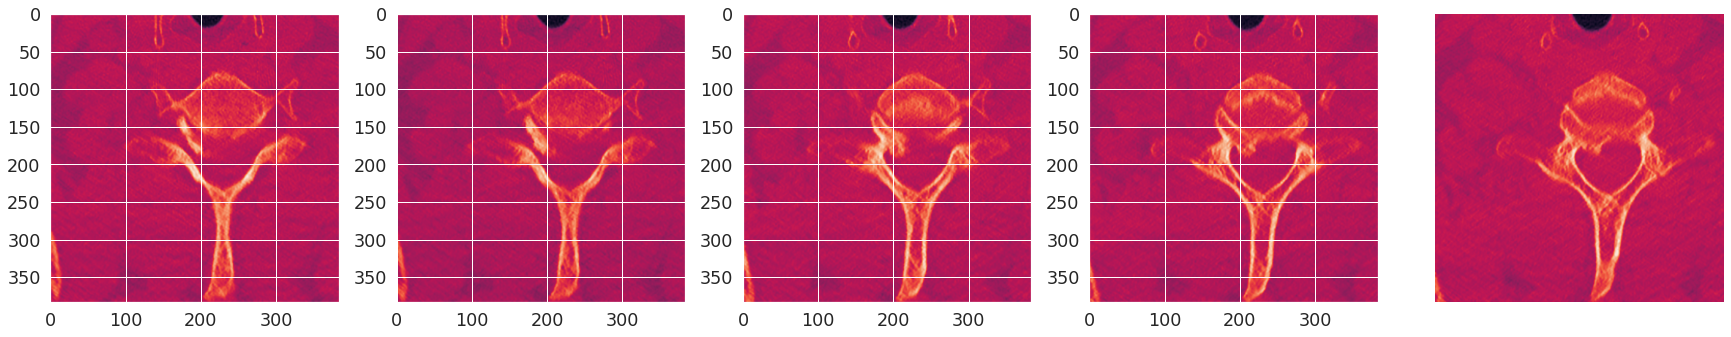

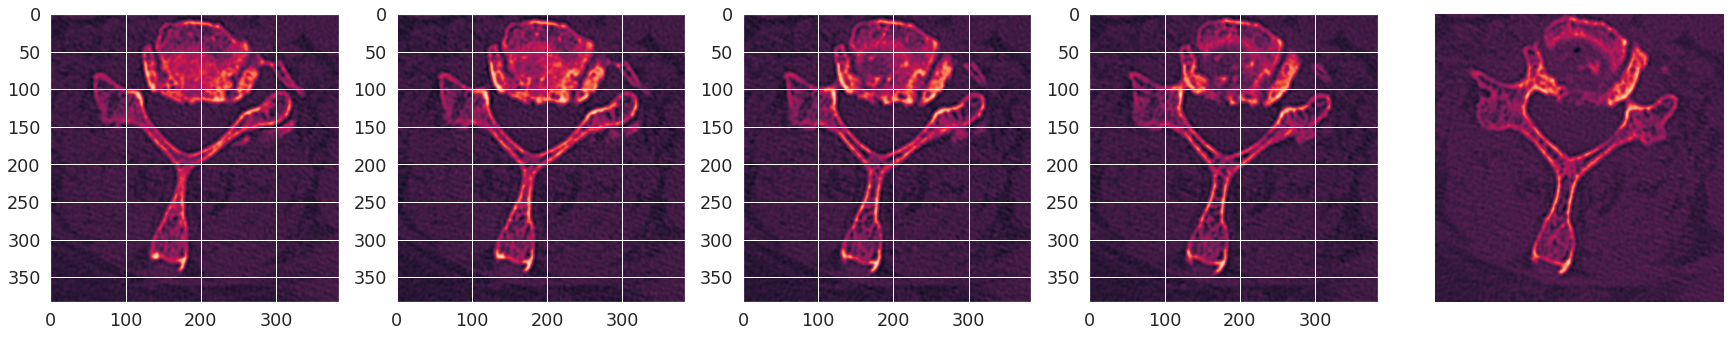

In [29]:
from pylab import rcParams
dataset_show = TestDataset(
    train_df,
    transform=get_transforms(data='valid') # None, get_transforms(data='check')
    )
rcParams['figure.figsize'] = 30,20
for i in range(2):
    f, axarr = plt.subplots(1,5)
    idx = np.random.randint(0, len(dataset_show))
    img = dataset_show[idx]
    # axarr[p].imshow(img) # transform=None
    axarr[0].imshow(img[0]); plt.axis('OFF');
    axarr[1].imshow(img[1]); plt.axis('OFF');
    axarr[2].imshow(img[2]); plt.axis('OFF');
    axarr[3].imshow(img[3]); plt.axis('OFF');
    axarr[4].imshow(img[4]); plt.axis('OFF');

In [30]:
import torch.nn as nn
from itertools import repeat

class SpatialDropout(nn.Module):
    def __init__(self, drop=0.5):
        super(SpatialDropout, self).__init__()
        self.drop = drop
        
    def forward(self, inputs, noise_shape=None):
        """
        @param: inputs, tensor
        @param: noise_shape, tuple
        """
        outputs = inputs.clone()
        if noise_shape is None:
            noise_shape = (inputs.shape[0], *repeat(1, inputs.dim()-2), inputs.shape[-1]) 
        
        self.noise_shape = noise_shape
        if not self.training or self.drop == 0:
            return inputs
        else:
            noises = self._make_noises(inputs)
            if self.drop == 1:
                noises.fill_(0.0)
            else:
                noises.bernoulli_(1 - self.drop).div_(1 - self.drop)
            noises = noises.expand_as(inputs)    
            outputs.mul_(noises)
            return outputs
            
    def _make_noises(self, inputs):
        return inputs.new().resize_(self.noise_shape)


import torch
from torch import nn
import torch.nn.functional as F

from typing import Dict, Optional
 
import numpy as np
import torch
import torch.nn.functional as F
from torch import Tensor


    
class MLPAttentionNetwork(nn.Module):
 
    def __init__(self, hidden_dim, attention_dim=None):
        super(MLPAttentionNetwork, self).__init__()
 
        self.hidden_dim = hidden_dim
        self.attention_dim = attention_dim
        if self.attention_dim is None:
            self.attention_dim = self.hidden_dim
        # W * x + b
        self.proj_w = nn.Linear(self.hidden_dim, self.attention_dim, bias=True)
        # v.T
        self.proj_v = nn.Linear(self.attention_dim, 1, bias=False)
 
    def forward(self, x):
        """
        :param x: seq_len, batch_size, hidden_dim
        :return: batch_size * seq_len, batch_size * hidden_dim
        """
        # print(f"x shape:{x.shape}")
        batch_size, seq_len, _ = x.size()
        # flat_inputs = x.reshape(-1, self.hidden_dim) # (batch_size*seq_len, hidden_dim)
        # print(f"flat_inputs shape:{flat_inputs.shape}")
        
        H = torch.tanh(self.proj_w(x)) # (batch_size, seq_len, hidden_dim)
        # print(f"H shape:{H.shape}")
        
        att_scores = torch.softmax(self.proj_v(H),axis=1) # (batch_size, seq_len)
        # print(f"att_scores shape:{att_scores.shape}")
        
        attn_x = (x * att_scores).sum(1) # (batch_size, hidden_dim)
        # print(f"attn_x shape:{attn_x.shape}")
        return attn_x

In [31]:
class RSNAClassifier(nn.Module):
    def __init__(self, model_arch, hidden_dim=256, seq_len=24, pretrained=False):
        super().__init__()
        self.seq_len = seq_len
        self.model = timm.create_model(model_arch, in_chans=1, pretrained=False)
        self.model_arch = model_arch

        if 'efficientnet' in self.model_arch:
            cnn_feature = self.model.classifier.in_features
            self.model.classifier = nn.Identity()
        elif "res" in self.model_arch:
            cnn_feature = self.model.fc.in_features
            self.model.global_pool = nn.Identity()
            self.model.fc = nn.Identity()
            self.pooling = nn.AdaptiveAvgPool2d(1)
        
        self.spatialdropout = SpatialDropout(CFG.dropout)
        self.gru = nn.GRU(cnn_feature, hidden_dim, 2, batch_first=True, bidirectional=True)
        self.mlp_attention_layer = MLPAttentionNetwork(2 * hidden_dim)
        self.logits = nn.Sequential(
            nn.Linear(hidden_dim*2, 128),
            nn.ReLU(),
            nn.Dropout(CFG.dropout),
            nn.Linear(128, 1)
        )

        # for n, m in self.named_modules():
        #     if isinstance(m, nn.GRU):
        #         print(f"init {m}")
        #         for param in m.parameters():
        #             if len(param.shape) >= 2:
        #                 nn.init.orthogonal_(param.data)
        #             else:
        #                 nn.init.normal_(param.data)

    def forward(self, x): # (B, seq_len, H, W)
        bs = x.size(0) 
        x = x.reshape(bs*self.seq_len, 1, x.size(2), x.size(3)) # (B*seq_len, 1, H, W)
        features = self.model(x)   
        if "res" in self.model_arch:                             
            features = self.pooling(features).view(bs*self.seq_len, -1) # (B*seq_len, cnn_feature)
        features = self.spatialdropout(features)                # (B*seq_len, cnn_feature)
        # print(features.shape)
        features = features.reshape(bs, self.seq_len, -1)       # (B, seq_len, cnn_feature)
        features, _ = self.gru(features)                        # (B, seq_len, hidden_dim*2)
        atten_out = self.mlp_attention_layer(features)          # (B, hidden_dim*2)
        pred = self.logits(atten_out)                           # (B, 1)
        pred = pred.view(bs, -1)                                # (B, 1)
        return pred

In [32]:
test_dataset = TestDataset(train_df, transform=get_transforms(data='valid'))
test_loader = DataLoader(test_dataset, batch_size=CFG.valid_bs, shuffle=False, num_workers=CFG.num_workers, pin_memory=True, drop_last=False)

cls_model_list = []
for m_arch, m_weight  in zip(CFG.archs_list, CFG.weights_list):
    
    model = RSNAClassifier(m_arch, hidden_dim=256, seq_len=24, pretrained=False)
    model.to(device)
    model.load_state_dict(torch.load(m_weight)["model"], strict=False)
    model.eval()

    cls_model_list.append(model)

RuntimeError: Error(s) in loading state_dict for RSNAClassifier:
	size mismatch for model.bn1.weight: copying a param with shape torch.Size([24]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for model.bn1.bias: copying a param with shape torch.Size([24]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for model.bn1.running_mean: copying a param with shape torch.Size([24]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for model.bn1.running_var: copying a param with shape torch.Size([24]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for gru.weight_ih_l0: copying a param with shape torch.Size([768, 1280]) from checkpoint, the shape in current model is torch.Size([768, 2048]).
	size mismatch for gru.weight_ih_l0_reverse: copying a param with shape torch.Size([768, 1280]) from checkpoint, the shape in current model is torch.Size([768, 2048]).

In [50]:
len(cls_model_list)

2

In [32]:
all_preds = []
for step, (images) in tqdm(enumerate(test_loader), total=len(test_loader)):
    images = images.to(device, dtype=torch.float) # study-cid:24*img_sz*img_sz
    models_preds = []
    for model in cls_model_list:
        with torch.no_grad(): 
            y_preds = model(images) # (B, 1)
            y_preds = y_preds.squeeze(1)
            models_preds.append(y_preds.sigmoid().to('cpu').numpy()) # list,len=model_nums,np(batch)
    models_preds = np.mean(models_preds, axis=0) # batch, one sample preds
    all_preds.append(models_preds)    
all_preds = np.concatenate(all_preds)

  0%|          | 0/2 [00:00<?, ?it/s]

OutOfMemoryError: CUDA out of memory. Tried to allocate 2.95 GiB (GPU 0; 47.54 GiB total capacity; 4.01 GiB already allocated; 1.07 GiB free; 5.96 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [ ]:
train_df["fractured"] = all_preds
model_preds_df = train_df[["StudyInstanceUID", "cid", "fractured"]]
print(model_preds_df.shape)
model_preds_df.head()

In [ ]:
def type_to_num(x):
    type_dict = {
        "C1":1,
        "C2":2,
        "C3":3,
        "C4":4,
        "C5":5,
        "C6":6,
        "C7":7,
        "patient_overall":8,
    }
    return type_dict[x]

test_df["cid"] = test_df["prediction_type"].apply(type_to_num)
print(test_df.shape)
test_df.head(8)

In [ ]:
test_df = test_df.merge(model_preds_df, how="left", on=["StudyInstanceUID", "cid"])
test_df["fractured"] = test_df["fractured"].fillna(CFG.fillna_number)
print(test_df.shape)
test_df.head(8)

In [ ]:
for study_id in test_study_list:
    # overall_fractured = test_df[test_df["StudyInstanceUID"]==study_id]["fractured"].max()
    overall_fractured = test_df[test_df["StudyInstanceUID"]==study_id]["fractured"][:7].agg(lambda x:1-((1-x).prod()))
    test_df.loc[((test_df["StudyInstanceUID"]==study_id) & (test_df["prediction_type"]=="patient_overall")), "fractured"] = overall_fractured
print(test_df.shape)
test_df

In [ ]:
final_df = test_df[["row_id", "fractured"]]
final_df.to_csv("submission.csv", index=False)
final_df